In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy import stats


## Preprocessing

### Raw Accelerometer Data GPT 50

In [3]:
gpt50 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_accel_embedding_gpt50.csv")
cig_risk = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/cig_risk.csv")

In [19]:
columns_to_exclude = ['Education', 'Married', 'BMI', 'combined', 'n_tokens', 'Age', 'PAD590', 'TV_Risk']
gpt50_prediction = gpt50[[col for col in gpt50.columns if col not in columns_to_exclude]]
healthy_participants = gpt50_prediction[(gpt50_prediction['Activity_Risk'] == False) & (gpt50_prediction['BMI_Risk'] == False)]['SEQN'].values
unhealthy_participants = gpt50_prediction[(gpt50_prediction['Activity_Risk'] == True) | (gpt50_prediction['BMI_Risk'] == True)]['SEQN'].values

### Raw Accelerometer Data GPT 1536

In [122]:
gpt1536 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide_embedding_gpt1536_clean.csv")

In [123]:
gpt1536 = gpt1536.merge(
    gpt50[['SEQN', 'BMXBMI', 'Activity_Risk', 'BMI_Risk']], 
    on='SEQN', 
    how='left'
).drop(columns=['BMI', 'Unnamed: 0', 'Married', 'Education'], errors='ignore')

### OTC Data GPT 50

In [20]:
gpt50_otc = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt50.csv")

In [21]:
gpt50_otc = gpt50_otc.merge(
    gpt50[['SEQN', 'Gender', 'Race', 'PIR', 'BMXBMI', 'Age', 'Activity_Risk', 'BMI_Risk']], 
    on='SEQN', 
    how='left'
)

### OTC Data GPT 1536

In [22]:
gpt1536_otc = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt1536.csv")

In [23]:
gpt1536_otc = gpt1536_otc.merge(
    gpt50[['SEQN', 'Gender', 'Race', 'PIR', 'BMXBMI', 'Age', 'Activity_Risk', 'BMI_Risk']], 
    on='SEQN', 
    how='left'
)

### OTC Data

In [24]:
otc_30 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/oct_raw_30.csv")

In [25]:
otc_30 = otc_30.rename(columns={'Unnamed: 0': 'SEQN'})

In [26]:
otc_30 = otc_30.merge(
    gpt50[['SEQN', 'Gender', 'Race', 'PIR', 'BMXBMI', 'Age', 'Activity_Risk', 'BMI_Risk']], 
    on='SEQN', 
    how='left'
)

In [27]:
otc_30.columns = otc_30.columns.astype(str)

## Modeling

### OTC Data

In [100]:
healthy_otc_raw = otc_30[otc_30['SEQN'].isin(healthy_participants)]
unhealthy_otc_raw = otc_30[otc_30['SEQN'].isin(unhealthy_participants)]

In [101]:
X = healthy_otc_raw.drop(columns=["Age", 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors="ignore")
y = healthy_otc_raw["Age"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr_otc_raw = LinearRegression()
lr_otc_raw.fit(X_train_scaled, y_train)
y_pred_otc_raw = lr_otc_raw.predict(X_test_scaled)
rmse_otc_raw = np.sqrt(mean_squared_error(y_test, y_pred_otc_raw))
r_otc_raw = stats.pearsonr(y_test, y_pred_otc_raw)[0]

print(f"RMSE for test set (healthy participants): {rmse_otc_raw}")
print(f"R for test set (healthy participants): {r_otc_raw}")

RMSE for test set (healthy participants): 17.158387716070624
R for test set (healthy participants): 0.4475585124629017


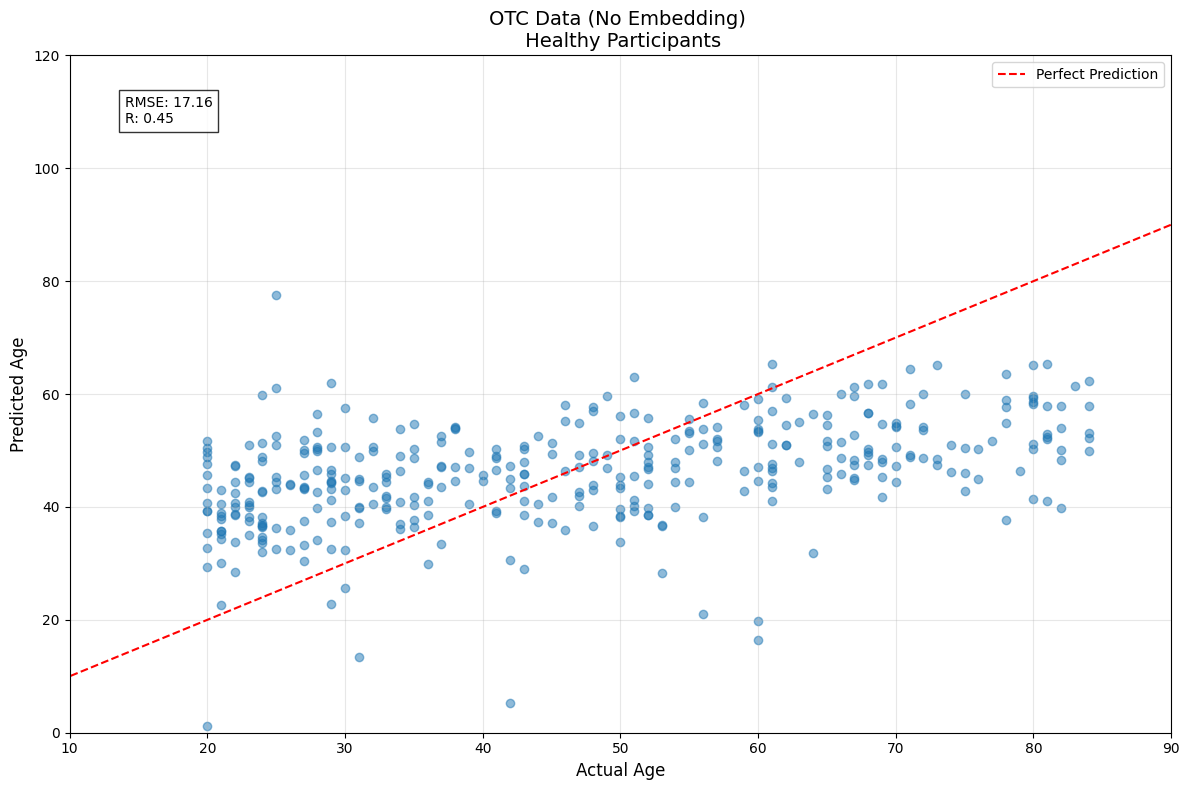


Prediction Statistics:
Mean Absolute Error: 14.44
Mean prediction: 46.05
Mean actual age: 46.51
Age range in test set: 20 to 84


In [102]:
plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred_otc_raw, alpha=0.5)

plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (No Embedding) \n Healthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()

metrics_text = f'RMSE: {rmse_otc_raw:.2f}\nR: {r_otc_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nPrediction Statistics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_otc_raw):.2f}")
print(f"Mean prediction: {y_pred_otc_raw.mean():.2f}")
print(f"Mean actual age: {y_test.mean():.2f}")
print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}")

In [103]:
X_unhealthy = unhealthy_otc_raw.drop(columns=['Age', 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors='ignore')
y_unhealthy = unhealthy_otc_raw['Age']

X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

y_pred_otc_raw_unhealthy = lr_otc_raw.predict(X_unhealthy_scaled)

In [104]:
unhealthy_otc_raw['n_risks'] = (
    unhealthy_otc_raw['Activity_Risk'].astype(int) + 
    unhealthy_otc_raw['BMI_Risk'].astype(int)
)

plot_data = pd.DataFrame({
    'actual': y_unhealthy,
    'predicted': y_pred_otc_raw_unhealthy,
    'SEQN': unhealthy_otc_raw['SEQN']
})
plot_data = plot_data.merge(
    unhealthy_otc_raw[['SEQN', 'n_risks']], 
    on='SEQN', 
    how='left'
)

rmse_uunhealthy_otc_raw = np.sqrt(mean_squared_error(y_unhealthy, y_pred_otc_raw_unhealthy))
r_unhealthy_otc_raw = stats.pearsonr(y_unhealthy, y_pred_otc_raw_unhealthy)[0]

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45488/5963405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhealthy_otc_raw['n_risks'] = (


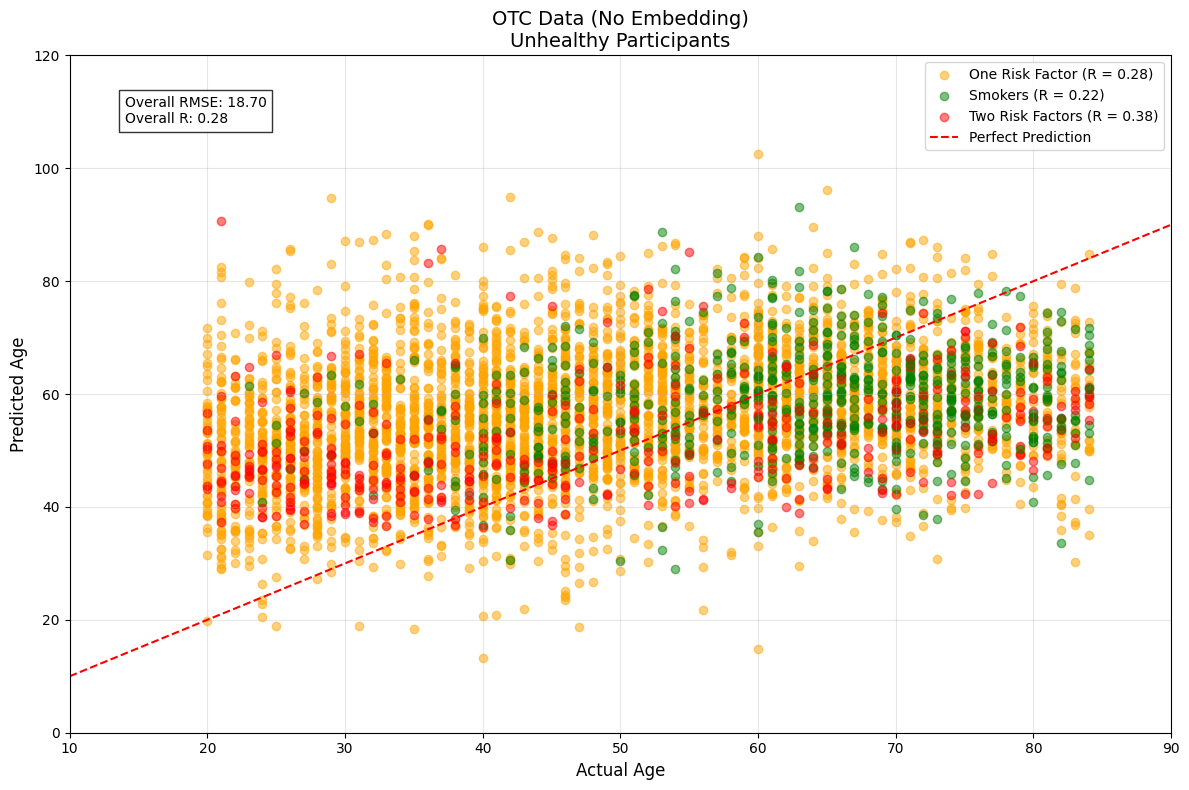


Detailed Statistics:
Number of smokers: 654

One Risk Factor:
Total participants: 4555
Number of smokers: 581
R: 0.278
Mean actual age: 50.06
Mean predicted age: 56.66

Two Risk Factors:
Total participants: 499
Number of smokers: 73
R: 0.383
Mean actual age: 51.39
Mean predicted age: 52.45


In [105]:
plt.figure(figsize=(12, 8))

colors = {1: 'orange', 2: 'red'}
labels = {1: 'One Risk Factor', 2: 'Two Risk Factors'}

# Calculate R for each risk group
r_by_risk = {}
for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    r_by_risk[n_risks] = stats.pearsonr(
        plot_data[mask]['actual'], 
        plot_data[mask]['predicted']
    )[0]
    
    # Split each risk group into smokers and non-smokers
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    smoker_r = stats.pearsonr(
        plot_data[smoker_mask]['actual'],
        plot_data[smoker_mask]['predicted']
    )[0]
    non_smoker_mask = mask & ~plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    # Plot non-smokers with original colors
    plt.scatter(
        plot_data[non_smoker_mask]['actual'], 
        plot_data[non_smoker_mask]['predicted'], 
        alpha=0.5, 
        color=colors[n_risks], 
        label=f"{labels[n_risks]} (R = {r_by_risk[n_risks]:.2f})"
    )
    
    # Plot smokers in green
    plt.scatter(
        plot_data[smoker_mask]['actual'], 
        plot_data[smoker_mask]['predicted'], 
        alpha=0.5, 
        color='green', 
        label=f"Smokers (R = {smoker_r:.2f})" if n_risks == 1 else ""
    )
    
plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (No Embedding)\nUnhealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

metrics_text = f'Overall RMSE: {rmse_uunhealthy_otc_raw:.2f}\nOverall R: {r_unhealthy_otc_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.show()

print("\nDetailed Statistics:")
smoker_mask = plot_data['SEQN'].isin(cig_risk['SEQN'])
print(f"Number of smokers: {smoker_mask.sum()}")

for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    print(f"\n{labels[n_risks]}:")
    print(f"Total participants: {mask.sum()}")
    print(f"Number of smokers: {smoker_mask.sum()}")
    print(f"R: {r_by_risk[n_risks]:.3f}")
    print(f"Mean actual age: {plot_data[mask]['actual'].mean():.2f}")
    print(f"Mean predicted age: {plot_data[mask]['predicted'].mean():.2f}")

Number of extreme over-predictions found: 682

Average actual age: 38.11
Average predicted age: 67.75


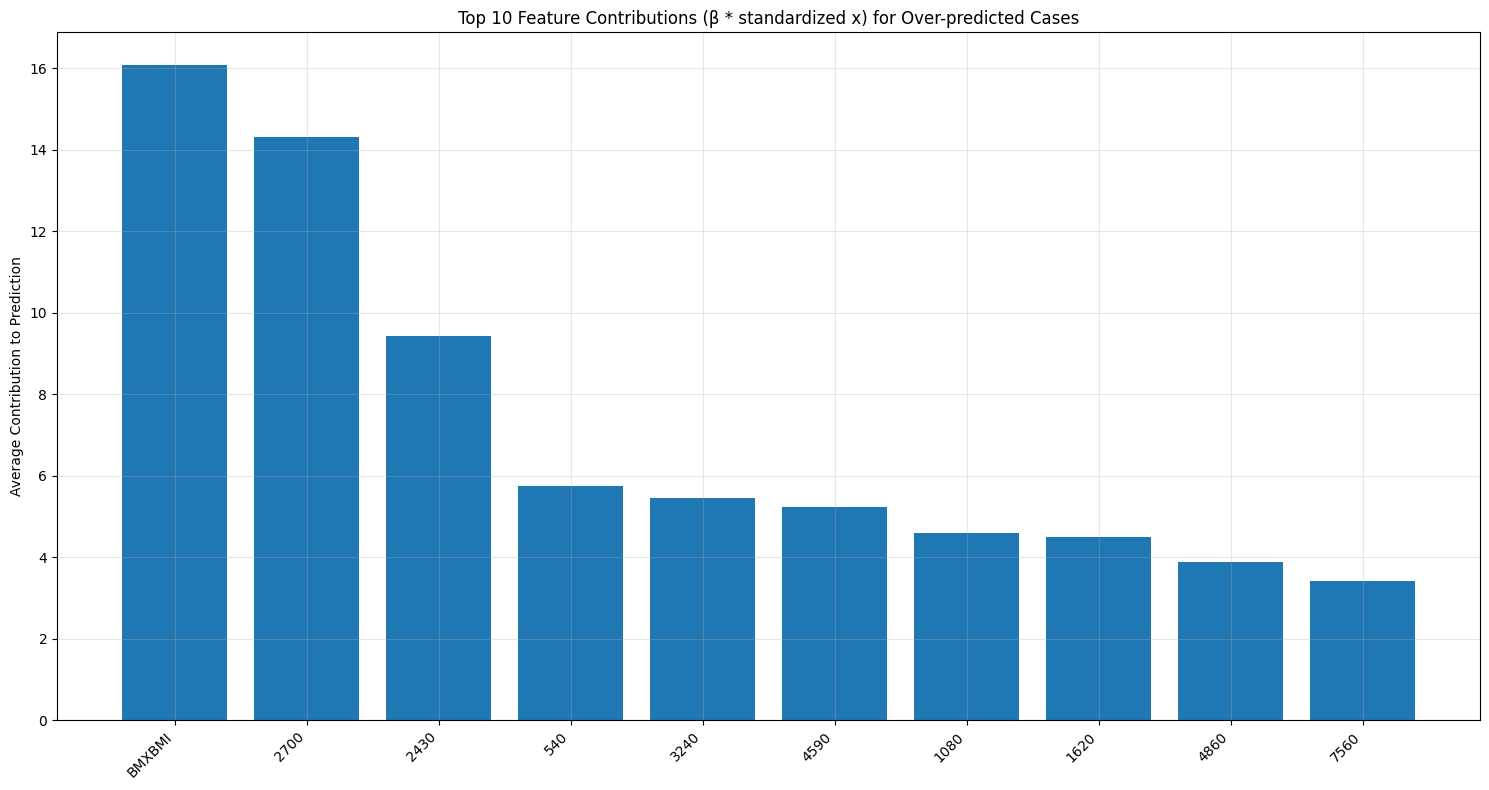


Detailed Analysis of Top Contributors:

Feature: BMXBMI
Beta (coefficient): 2.1092
Average standardized X value: 7.6236
Average contribution (β * standardized x): 16.0799
Range of standardized X values: 1.3527 to 55.0036

Feature: 2700
Beta (coefficient): -29.9702
Average standardized X value: -0.4777
Average contribution (β * standardized x): 14.3168
Range of standardized X values: -0.8575 to 2.0154

Feature: 2430
Beta (coefficient): 19.9511
Average standardized X value: -0.4726
Average contribution (β * standardized x): 9.4295
Range of standardized X values: -0.9307 to 1.9027

Feature: 540
Beta (coefficient): -25.4903
Average standardized X value: -0.2253
Average contribution (β * standardized x): 5.7421
Range of standardized X values: -1.8703 to 2.8327

Feature: 3240
Beta (coefficient): 12.0040
Average standardized X value: -0.4548
Average contribution (β * standardized x): 5.4592
Range of standardized X values: -0.7168 to 2.3003

Feature: 4590
Beta (coefficient): -14.2515
Average 

In [36]:
mask = (plot_data['actual'].between(20, 50)) & (plot_data['predicted'] > 60)
extreme_cases = plot_data[mask].copy()

extreme_features = X_unhealthy_scaled[X_unhealthy_scaled.index.isin(extreme_cases.index)]
coefficients = pd.Series(lr_otc_raw.coef_, index=X_unhealthy_scaled.columns)

feature_contributions = extreme_features * coefficients

avg_contributions = feature_contributions.mean()
top_contributors = avg_contributions.abs().sort_values(ascending=False).head(10)

print(f"Number of extreme over-predictions found: {len(extreme_cases)}")
print(f"\nAverage actual age: {extreme_cases['actual'].mean():.2f}")
print(f"Average predicted age: {extreme_cases['predicted'].mean():.2f}")

plt.figure(figsize=(15, 8))
plt.bar(range(len(top_contributors)), top_contributors.values)
plt.xticks(range(len(top_contributors)), top_contributors.index, rotation=45, ha='right')
plt.title('Top 10 Feature Contributions (β * standardized x) for Over-predicted Cases')
plt.ylabel('Average Contribution to Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetailed Analysis of Top Contributors:")
for feature in top_contributors.index:
    print(f"\nFeature: {feature}")
    print(f"Beta (coefficient): {coefficients[feature]:.4f}")
    print(f"Average standardized X value: {extreme_features[feature].mean():.4f}")
    print(f"Average contribution (β * standardized x): {top_contributors[feature]:.4f}")
    print(f"Range of standardized X values: {extreme_features[feature].min():.4f} to {extreme_features[feature].max():.4f}")

### Raw Accelerometer Data GPT 50

In [155]:
healthy_gpt50_raw = gpt50_prediction[gpt50_prediction['SEQN'].isin(healthy_participants)]

In [156]:
X = healthy_gpt50_raw.drop(columns=["RIDAGEYR", 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors="ignore")
y = healthy_gpt50_raw["RIDAGEYR"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr_gpt50_raw = LinearRegression()
lr_gpt50_raw.fit(X_train_scaled, y_train)
y_pred_gpt50_raw = lr_gpt50_raw.predict(X_test_scaled)
rmse_gpt50_raw = np.sqrt(mean_squared_error(y_test, y_pred_gpt50_raw))
r_gpt50_raw = stats.pearsonr(y_test, y_pred_gpt50_raw)[0]

print(f"RMSE for test set (healthy participants): {rmse_gpt50_raw}")
print(f"R Squared for test set (healthy participants): {r_gpt50_raw}")

RMSE for test set (healthy participants): 14.858534080696572
R Squared for test set (healthy participants): 0.6072151850321239


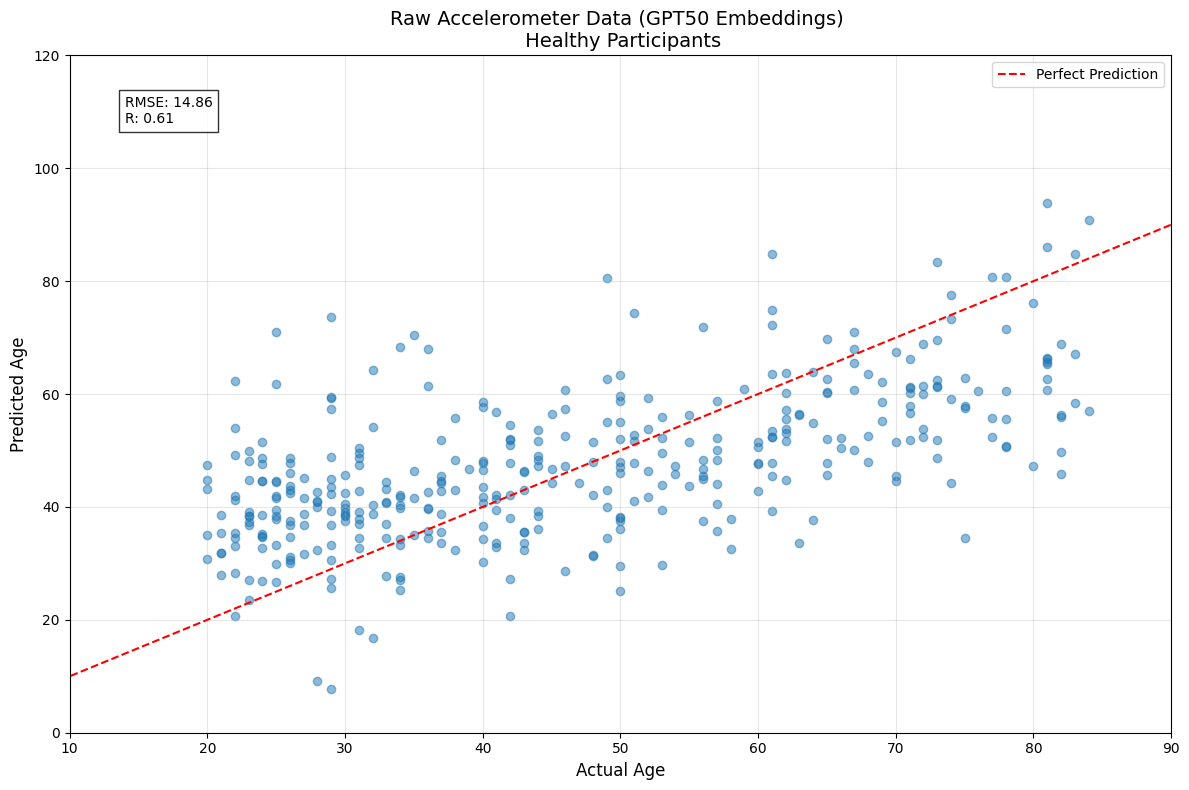


Prediction Statistics:
Mean Absolute Error: 12.08
Mean prediction: 47.32
Mean actual age: 46.51
Age range in test set: 20 to 84


In [157]:
plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred_gpt50_raw, alpha=0.5)

plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Raw Accelerometer Data (GPT50 Embeddings) \n Healthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()

metrics_text = f'RMSE: {rmse_gpt50_raw:.2f}\nR: {r_gpt50_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nPrediction Statistics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt50_raw):.2f}")
print(f"Mean prediction: {y_pred_gpt50_raw.mean():.2f}")
print(f"Mean actual age: {y_test.mean():.2f}")
print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}")

In [158]:
unhealthy_gpt50_raw = gpt50_prediction[gpt50_prediction['SEQN'].isin(unhealthy_participants)]

In [159]:
X_unhealthy = unhealthy_gpt50_raw.drop(columns=['RIDAGEYR', 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors='ignore')
y_unhealthy = unhealthy_gpt50_raw['RIDAGEYR']

X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

y_pred_gpt50_raw_unhealthy = lr_gpt50_raw.predict(X_unhealthy_scaled)

In [160]:
unhealthy_gpt50_raw['n_risks'] = (
    unhealthy_gpt50_raw['Activity_Risk'].astype(int) + 
    unhealthy_gpt50_raw['BMI_Risk'].astype(int)
)

plot_data = pd.DataFrame({
    'actual': y_unhealthy,
    'predicted': y_pred_gpt50_raw_unhealthy,
    'SEQN': unhealthy_gpt50_raw['SEQN']
})
plot_data = plot_data.merge(
    unhealthy_gpt50_raw[['SEQN', 'n_risks']], 
    on='SEQN', 
    how='left'
)

rmse_unhealthy_gpt50_raw = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt50_raw_unhealthy))
r_unhealthy_gpt50_raw = stats.pearsonr(y_unhealthy, y_pred_gpt50_raw_unhealthy)[0]

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45488/1018567160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhealthy_gpt50_raw['n_risks'] = (


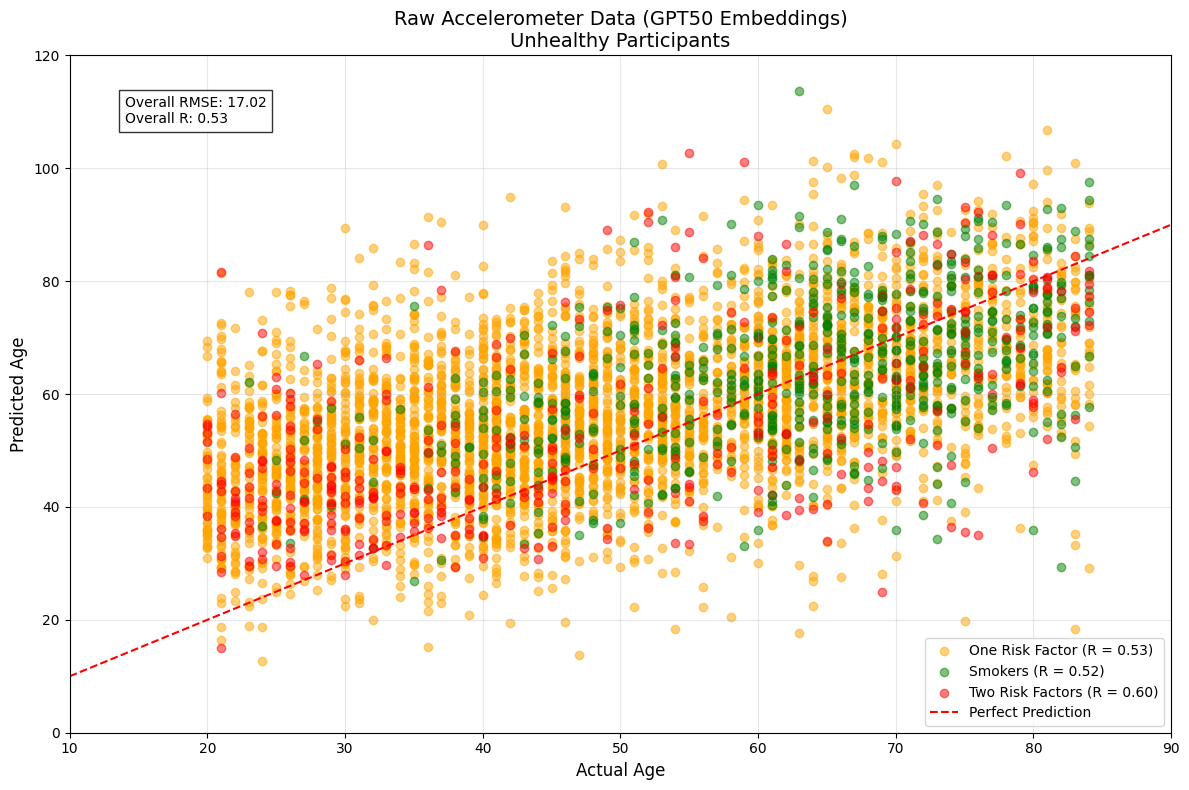


Detailed Statistics:
Number of smokers: 654

One Risk Factor:
Total participants: 4555
Number of smokers: 581
R: 0.525
Mean actual age: 50.06
Mean predicted age: 57.26

Two Risk Factors:
Total participants: 499
Number of smokers: 73
R: 0.601
Mean actual age: 51.39
Mean predicted age: 55.65


In [161]:
plt.figure(figsize=(12, 8))

colors = {1: 'orange', 2: 'red'}
labels = {1: 'One Risk Factor', 2: 'Two Risk Factors'}

# Calculate R for each risk group
r_by_risk = {}
for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    r_by_risk[n_risks] = stats.pearsonr(
        plot_data[mask]['actual'], 
        plot_data[mask]['predicted']
    )[0]
    
    # Split each risk group into smokers and non-smokers
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    smoker_r = stats.pearsonr(
        plot_data[smoker_mask]['actual'],
        plot_data[smoker_mask]['predicted']
    )[0]
    non_smoker_mask = mask & ~plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    # Plot non-smokers with original colors
    plt.scatter(
        plot_data[non_smoker_mask]['actual'], 
        plot_data[non_smoker_mask]['predicted'], 
        alpha=0.5, 
        color=colors[n_risks], 
        label=f"{labels[n_risks]} (R = {r_by_risk[n_risks]:.2f})"
    )
    
    # Plot smokers in green
    plt.scatter(
        plot_data[smoker_mask]['actual'], 
        plot_data[smoker_mask]['predicted'], 
        alpha=0.5, 
        color='green', 
        label=f"Smokers (R = {smoker_r:.2f})" if n_risks == 1 else "" 
    )
    
plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Raw Accelerometer Data (GPT50 Embeddings)\nUnhealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

metrics_text = f'Overall RMSE: {rmse_unhealthy_gpt50_raw:.2f}\nOverall R: {r_unhealthy_gpt50_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.show()

print("\nDetailed Statistics:")
smoker_mask = plot_data['SEQN'].isin(cig_risk['SEQN'])
print(f"Number of smokers: {smoker_mask.sum()}")

for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    print(f"\n{labels[n_risks]}:")
    print(f"Total participants: {mask.sum()}")
    print(f"Number of smokers: {smoker_mask.sum()}")
    print(f"R: {r_by_risk[n_risks]:.3f}")
    print(f"Mean actual age: {plot_data[mask]['actual'].mean():.2f}")
    print(f"Mean predicted age: {plot_data[mask]['predicted'].mean():.2f}")

Number of extreme over-predictions found: 552

Average actual age: 38.98
Average predicted age: 68.13


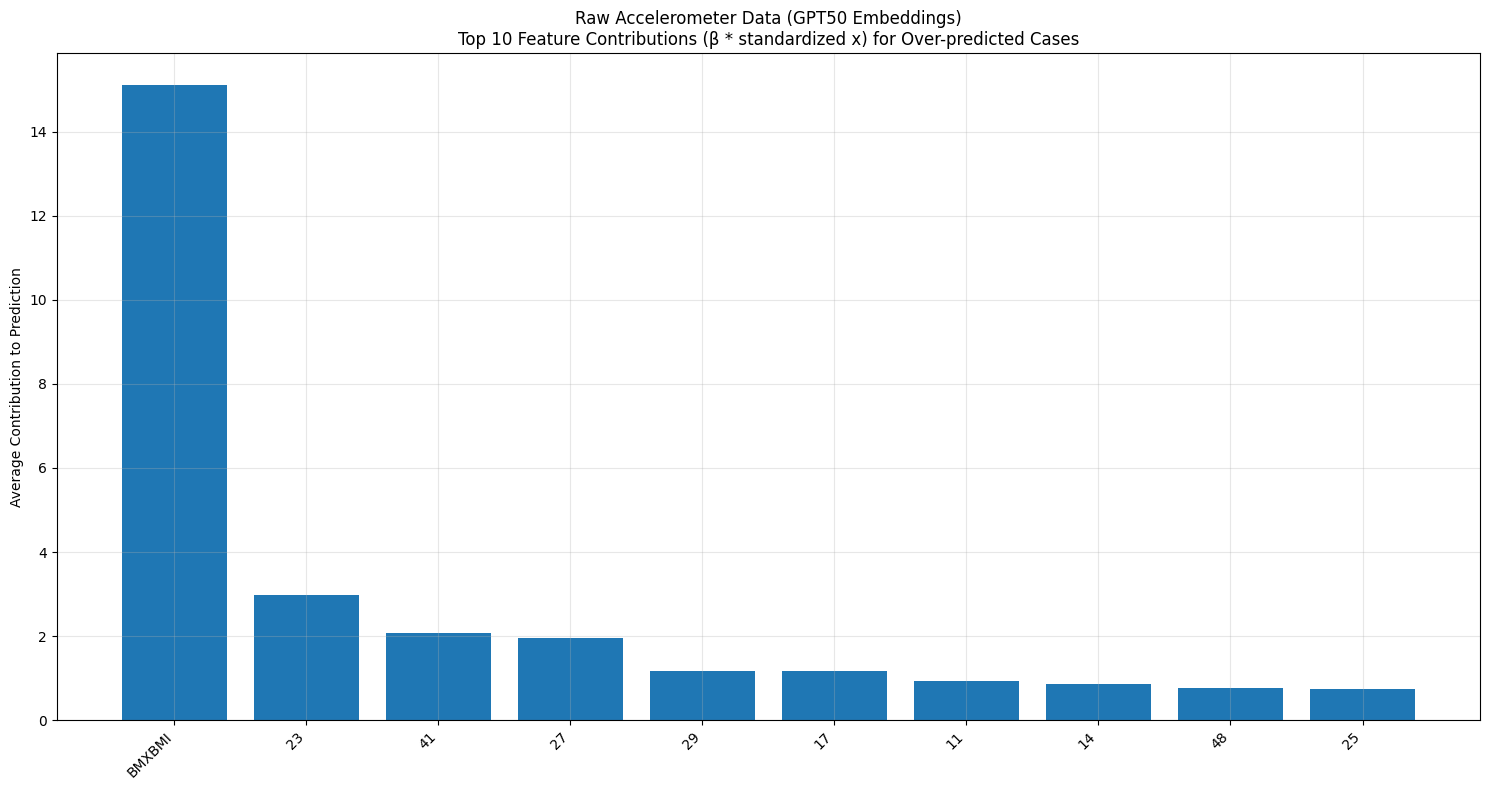


Detailed Analysis of Top Contributors:

Feature: BMXBMI
Beta (coefficient): 2.0751
Average standardized X value: 7.2816
Average contribution (β * standardized x): 15.1103
Range of standardized X values: -0.8552 to 53.5910

Feature: 23
Beta (coefficient): 6.7701
Average standardized X value: 0.4388
Average contribution (β * standardized x): 2.9709
Range of standardized X values: -3.1396 to 2.7944

Feature: 41
Beta (coefficient): -7.7250
Average standardized X value: 0.2695
Average contribution (β * standardized x): 2.0816
Range of standardized X values: -2.4877 to 3.1835

Feature: 27
Beta (coefficient): -4.0155
Average standardized X value: -0.4855
Average contribution (β * standardized x): 1.9496
Range of standardized X values: -3.1819 to 2.3243

Feature: 29
Beta (coefficient): 3.3486
Average standardized X value: 0.3498
Average contribution (β * standardized x): 1.1715
Range of standardized X values: -2.5378 to 2.1195

Feature: 17
Beta (coefficient): 2.5890
Average standardized X val

In [162]:
mask = (plot_data['actual'].between(20, 50)) & (plot_data['predicted'] > 60)
extreme_cases = plot_data[mask].copy()

extreme_features = X_unhealthy_scaled[X_unhealthy_scaled.index.isin(extreme_cases.index)]
coefficients = pd.Series(lr_gpt50_raw.coef_, index=X_unhealthy_scaled.columns)

feature_contributions = extreme_features * coefficients

avg_contributions = feature_contributions.mean()
top_contributors = avg_contributions.abs().sort_values(ascending=False).head(10)

print(f"Number of extreme over-predictions found: {len(extreme_cases)}")
print(f"\nAverage actual age: {extreme_cases['actual'].mean():.2f}")
print(f"Average predicted age: {extreme_cases['predicted'].mean():.2f}")

plt.figure(figsize=(15, 8))
plt.bar(range(len(top_contributors)), top_contributors.values)
plt.xticks(range(len(top_contributors)), top_contributors.index, rotation=45, ha='right')
plt.title('Raw Accelerometer Data (GPT50 Embeddings)\nTop 10 Feature Contributions (β * standardized x) for Over-predicted Cases')
plt.ylabel('Average Contribution to Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetailed Analysis of Top Contributors:")
for feature in top_contributors.index:
    print(f"\nFeature: {feature}")
    print(f"Beta (coefficient): {coefficients[feature]:.4f}")
    print(f"Average standardized X value: {extreme_features[feature].mean():.4f}")
    print(f"Average contribution (β * standardized x): {top_contributors[feature]:.4f}")
    print(f"Range of standardized X values: {extreme_features[feature].min():.4f} to {extreme_features[feature].max():.4f}")

### Raw Accelerometer Data GPT 1536

In [172]:
healthy_gpt1536_raw = gpt1536[gpt1536['SEQN'].isin(healthy_participants)]
unhealthy_gpt1536_raw = gpt1536[gpt1536['SEQN'].isin(unhealthy_participants)]

In [173]:
X = healthy_gpt1536_raw.drop(columns=["Age", 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors="ignore")
y = healthy_gpt1536_raw["Age"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

ridge_raw1536 = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
ridge_raw1536.fit(X_train_scaled, y_train)

y_pred_gpt1536_raw = ridge_raw1536.predict(X_test_scaled)
rmse_gpt1536_raw = np.sqrt(mean_squared_error(y_test, y_pred_gpt1536_raw))
r_gpt1536_raw = stats.pearsonr(y_test, y_pred_gpt1536_raw)[0]

print(f"RMSE for test set (healthy participants): {rmse_gpt1536_raw}")
print(f"R Squared for test set (healthy participants): {r_gpt1536_raw}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RMSE for test set (healthy participants): 13.532820443272506
R Squared for test set (healthy participants): 0.686103902049309


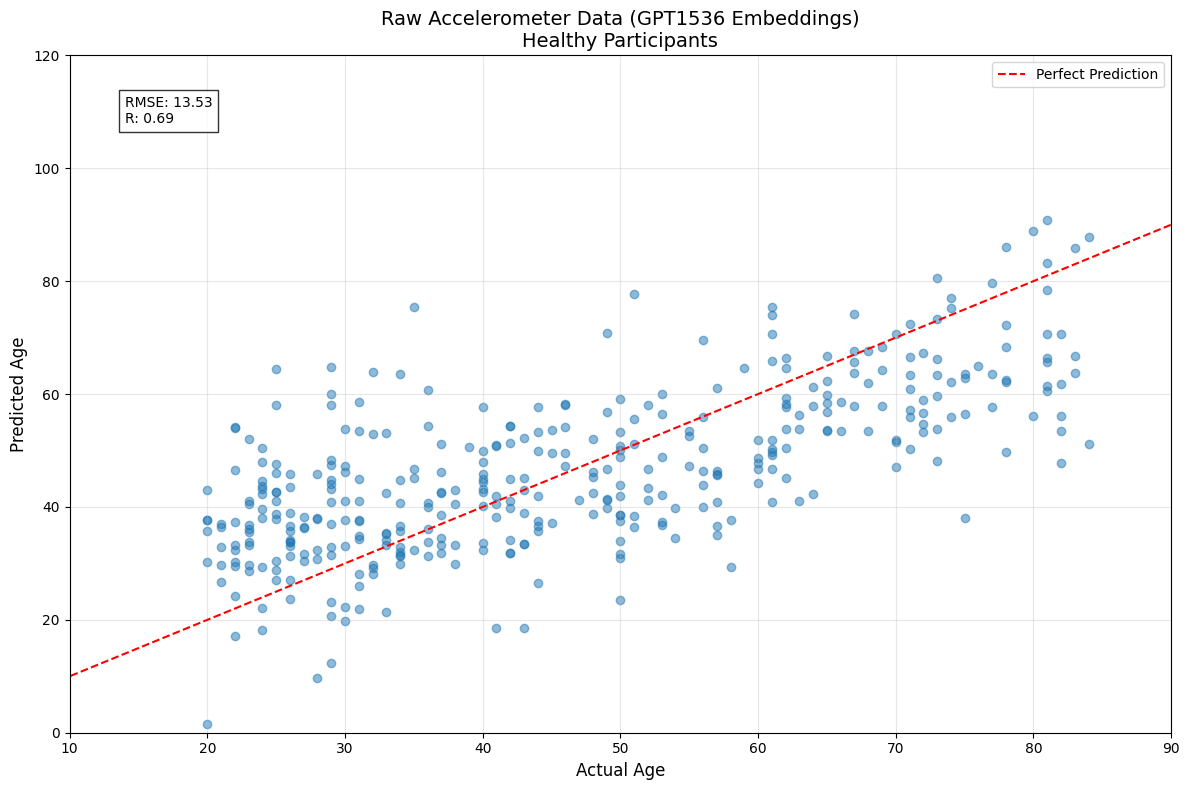


Prediction Statistics:
Mean Absolute Error: 10.94
Mean prediction: 46.70
Mean actual age: 46.51
Age range in test set: 20 to 84


In [174]:
plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred_gpt1536_raw, alpha=0.5)

plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Raw Accelerometer Data (GPT1536 Embeddings)\nHealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()

metrics_text = f'RMSE: {rmse_gpt1536_raw:.2f}\nR: {r_gpt1536_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nPrediction Statistics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt1536_raw):.2f}")
print(f"Mean prediction: {y_pred_gpt1536_raw.mean():.2f}")
print(f"Mean actual age: {y_test.mean():.2f}")
print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}")

In [175]:
X_unhealthy = unhealthy_gpt1536_raw.drop(columns=['Age', 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors='ignore')
y_unhealthy = unhealthy_gpt1536_raw['Age']

X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

y_pred_gpt1536_raw_unhealthy = ridge_raw1536.predict(X_unhealthy_scaled)

In [176]:
unhealthy_gpt1536_raw['n_risks'] = (
    unhealthy_gpt1536_raw['Activity_Risk'].astype(int) + 
    unhealthy_gpt1536_raw['BMI_Risk'].astype(int)
)

plot_data = pd.DataFrame({
    'actual': y_unhealthy,
    'predicted': y_pred_gpt1536_raw_unhealthy,
    'SEQN': unhealthy_gpt1536_raw['SEQN']
})
plot_data = plot_data.merge(
    unhealthy_gpt1536_raw[['SEQN', 'n_risks']], 
    on='SEQN', 
    how='left'
)

rmse_unhealthy_gpt1536_raw = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt1536_raw_unhealthy))
r_unhealthy_gpt1536_raw = stats.pearsonr(y_unhealthy, y_pred_gpt1536_raw_unhealthy)[0]

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45488/1341967936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhealthy_gpt1536_raw['n_risks'] = (


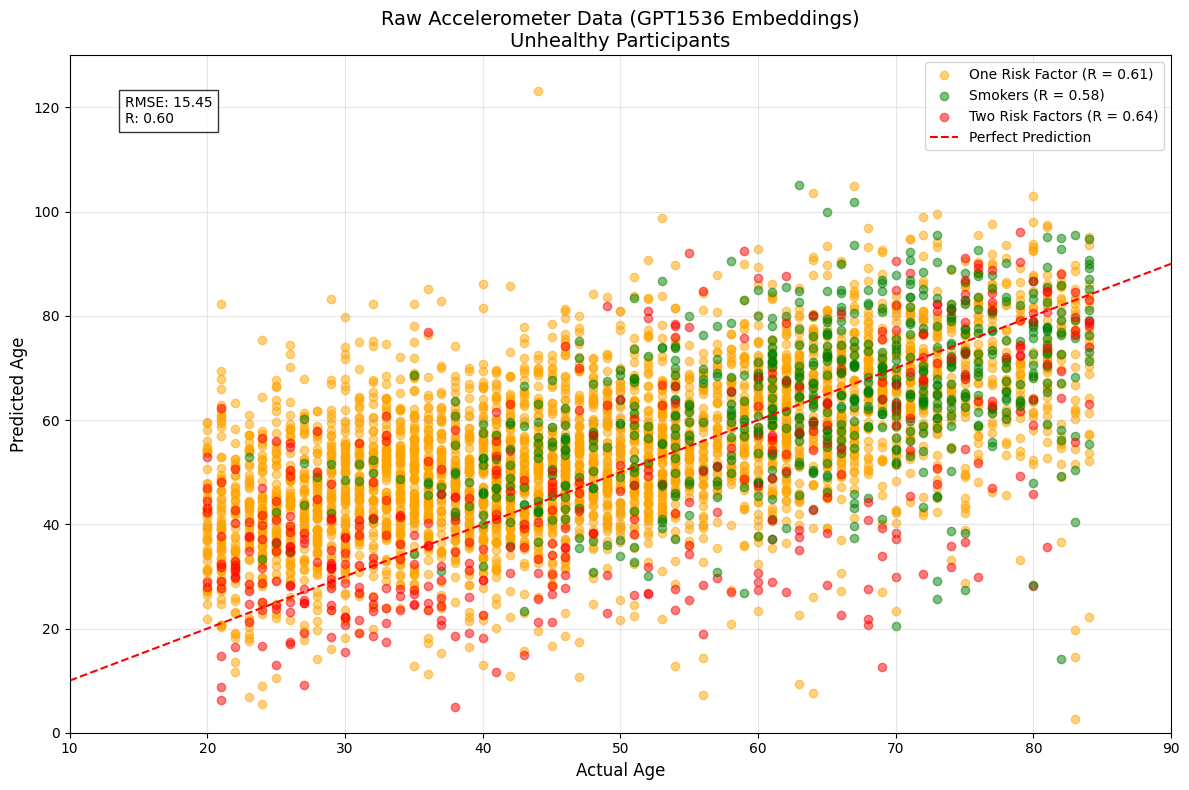


Detailed Statistics:
Number of smokers: 654

One Risk Factor:
Total participants: 4555
Number of smokers: 581
R: 0.608
Mean actual age: 50.06
Mean predicted age: 55.22

Two Risk Factors:
Total participants: 499
Number of smokers: 73
R: 0.643
Mean actual age: 51.39
Mean predicted age: 48.86


In [177]:
plt.figure(figsize=(12, 8))

colors = {1: 'orange', 2: 'red'}
labels = {1: 'One Risk Factor', 2: 'Two Risk Factors'}

r_by_risk = {}
for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    r_by_risk[n_risks] = stats.pearsonr(
        plot_data[mask]['actual'], 
        plot_data[mask]['predicted']
    )[0]
    
    # Split each risk group into smokers and non-smokers
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    smoker_r = stats.pearsonr(
        plot_data[smoker_mask]['actual'],
        plot_data[smoker_mask]['predicted']
    )[0]
    non_smoker_mask = mask & ~plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    # Plot non-smokers with original colors
    plt.scatter(
        plot_data[non_smoker_mask]['actual'], 
        plot_data[non_smoker_mask]['predicted'], 
        alpha=0.5, 
        color=colors[n_risks], 
        label=f"{labels[n_risks]} (R = {r_by_risk[n_risks]:.2f})"
    )
    
    # Plot smokers in green
    plt.scatter(
        plot_data[smoker_mask]['actual'], 
        plot_data[smoker_mask]['predicted'], 
        alpha=0.5, 
        color='green', 
        label=f"Smokers (R = {smoker_r:.2f})" if n_risks == 1 else ""  # Only add label once
    )


plt.plot([10, 130], [10, 130], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 130)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Raw Accelerometer Data (GPT1536 Embeddings)\nUnhealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

metrics_text = f'RMSE: {rmse_unhealthy_gpt1536_raw:.2f}\nR: {r_unhealthy_gpt1536_raw:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
smoker_mask = plot_data['SEQN'].isin(cig_risk['SEQN'])
print(f"Number of smokers: {smoker_mask.sum()}")

for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    print(f"\n{labels[n_risks]}:")
    print(f"Total participants: {mask.sum()}")
    print(f"Number of smokers: {smoker_mask.sum()}")
    print(f"R: {r_by_risk[n_risks]:.3f}")
    print(f"Mean actual age: {plot_data[mask]['actual'].mean():.2f}")
    print(f"Mean predicted age: {plot_data[mask]['predicted'].mean():.2f}")

Number of extreme over-predictions found: 349

Average actual age: 39.89
Average predicted age: 67.02


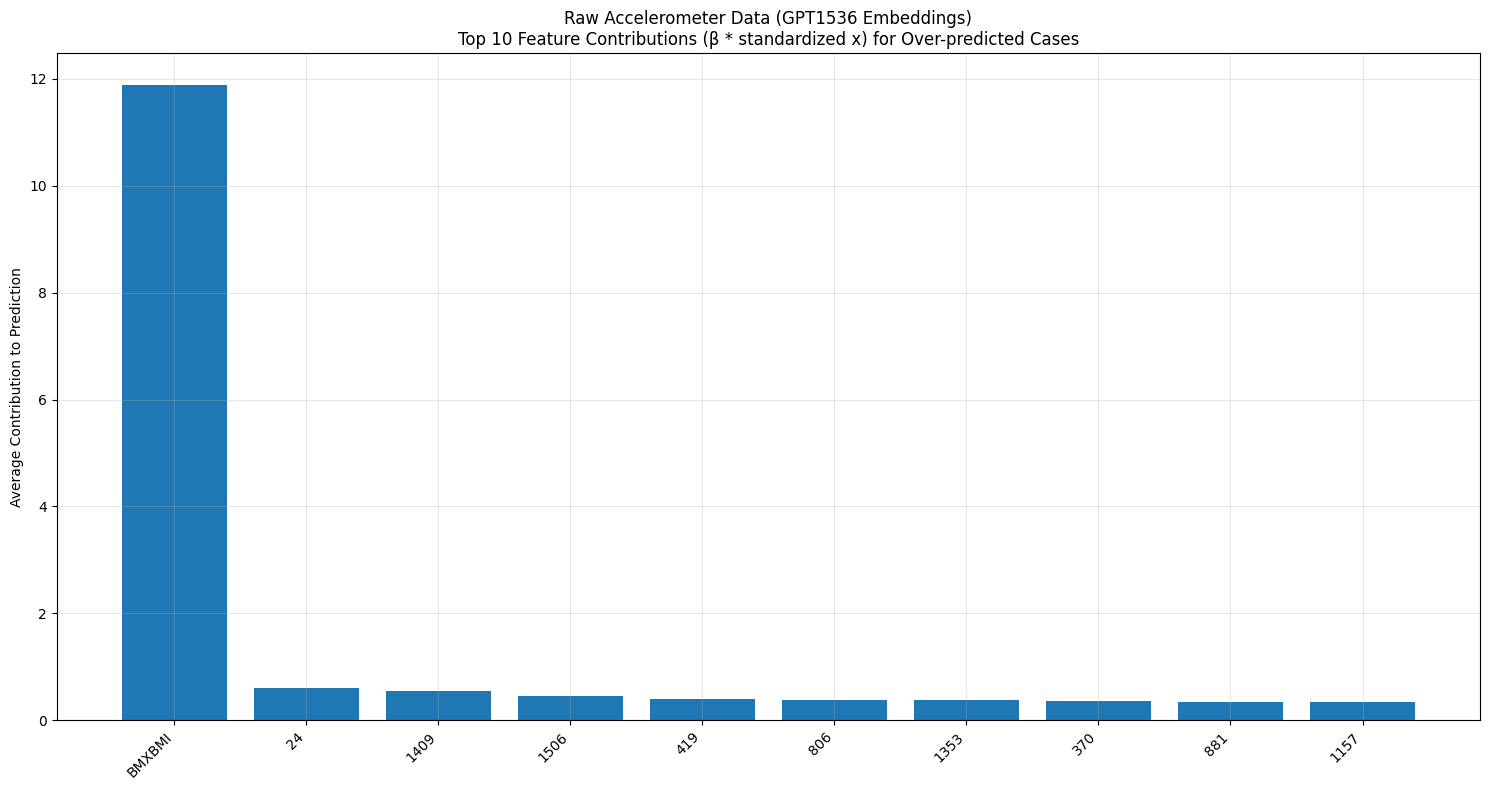


Detailed Analysis of Top Contributors:

Feature: BMXBMI
Beta (coefficient): 1.5919
Average standardized X value: 7.4672
Average contribution (β * standardized x): 11.8873
Range of standardized X values: 1.1323 to 53.5910

Feature: 24
Beta (coefficient): 1.0611
Average standardized X value: 0.5680
Average contribution (β * standardized x): 0.6027
Range of standardized X values: -3.7392 to 1.8041

Feature: 1409
Beta (coefficient): 1.4089
Average standardized X value: 0.3828
Average contribution (β * standardized x): 0.5394
Range of standardized X values: -2.3491 to 2.7557

Feature: 1506
Beta (coefficient): -0.8081
Average standardized X value: 0.5518
Average contribution (β * standardized x): 0.4460
Range of standardized X values: -2.6435 to 3.2599

Feature: 419
Beta (coefficient): 0.7050
Average standardized X value: -0.5544
Average contribution (β * standardized x): 0.3909
Range of standardized X values: -2.8853 to 3.1521

Feature: 806
Beta (coefficient): 0.9355
Average standardized X

In [179]:
new_columns = [col.replace('var', '') if col.startswith('var') else col for col in X_unhealthy_scaled.columns]
X_unhealthy_scaled.columns = new_columns


mask = (plot_data['actual'].between(20, 50)) & (plot_data['predicted'] > 60)
extreme_cases = plot_data[mask].copy()

extreme_features = X_unhealthy_scaled[X_unhealthy_scaled.index.isin(extreme_cases.index)]
coefficients = pd.Series(ridge_raw1536.coef_, index=X_unhealthy_scaled.columns)

feature_contributions = extreme_features * coefficients

avg_contributions = feature_contributions.mean()
top_contributors = avg_contributions.abs().sort_values(ascending=False).head(10)

print(f"Number of extreme over-predictions found: {len(extreme_cases)}")
print(f"\nAverage actual age: {extreme_cases['actual'].mean():.2f}")
print(f"Average predicted age: {extreme_cases['predicted'].mean():.2f}")

plt.figure(figsize=(15, 8))
plt.bar(range(len(top_contributors)), top_contributors.values)
plt.xticks(range(len(top_contributors)), top_contributors.index, rotation=45, ha='right')
plt.title('Raw Accelerometer Data (GPT1536 Embeddings)\nTop 10 Feature Contributions (β * standardized x) for Over-predicted Cases')
plt.ylabel('Average Contribution to Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetailed Analysis of Top Contributors:")
for feature in top_contributors.index:
    print(f"\nFeature: {feature}")
    print(f"Beta (coefficient): {coefficients[feature]:.4f}")
    print(f"Average standardized X value: {extreme_features[feature].mean():.4f}")
    print(f"Average contribution (β * standardized x): {top_contributors[feature]:.4f}")
    print(f"Range of standardized X values: {extreme_features[feature].min():.4f} to {extreme_features[feature].max():.4f}")

### OTC Data GPT50

In [140]:
healthy_gpt50_otc = gpt50_otc[gpt50_otc['SEQN'].isin(healthy_participants)]
unhealthy_gpt50_otc = gpt50_otc[gpt50_otc['SEQN'].isin(unhealthy_participants)]

In [141]:
X = healthy_gpt50_otc.drop(columns=["Age", 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors="ignore")
y = healthy_gpt50_otc["Age"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr_gpt50_otc = LinearRegression()
lr_gpt50_otc.fit(X_train_scaled, y_train)
y_pred_gpt50_otc = lr_gpt50_otc.predict(X_test_scaled)
rmse_gpt50_otc = np.sqrt(mean_squared_error(y_test, y_pred_gpt50_otc))
r_gpt50_otc = stats.pearsonr(y_test, y_pred_gpt50_otc)[0]

print(f"RMSE for test set (healthy participants): {rmse_gpt50_otc}")
print(f"R Squared for test set (healthy participants): {r_gpt50_otc}")

RMSE for test set (healthy participants): 15.908091819938676
R Squared for test set (healthy participants): 0.5583192446010927


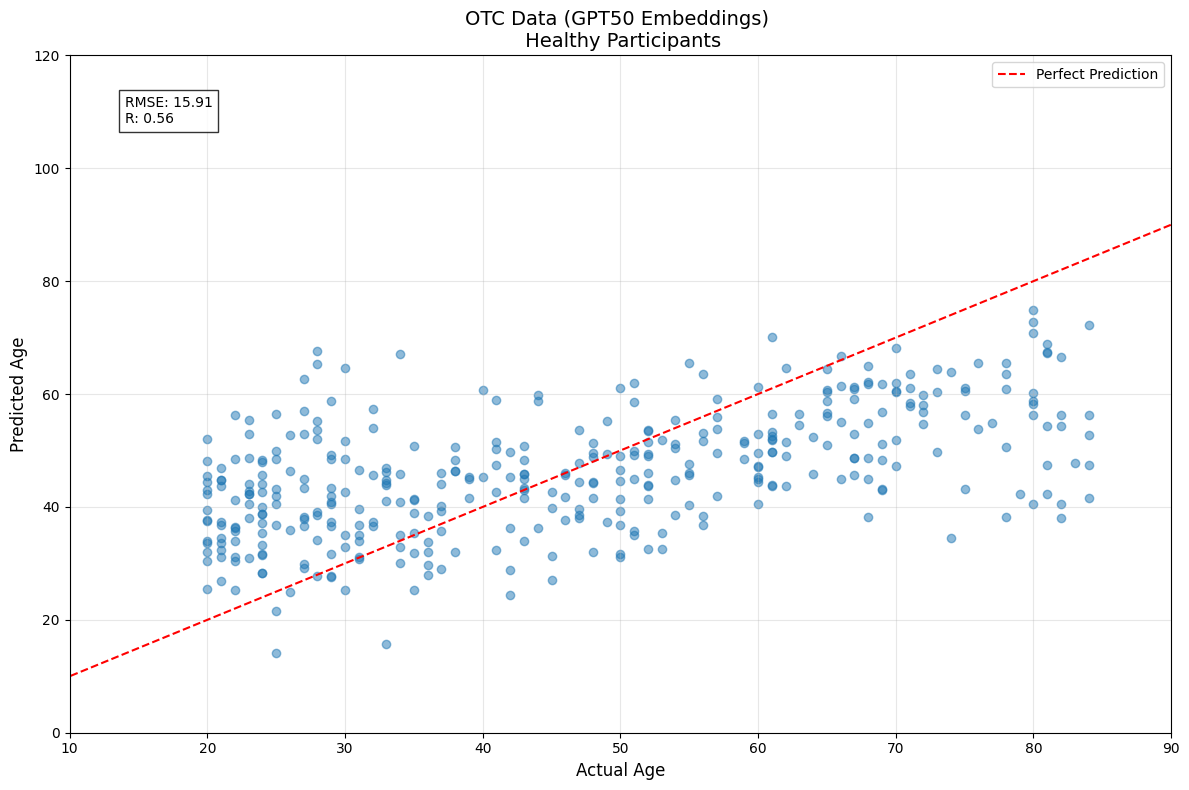


Prediction Statistics:
Mean Absolute Error: 12.90
Mean prediction: 46.11
Mean actual age: 46.51
Age range in test set: 20 to 84


In [142]:
plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred_gpt50_otc, alpha=0.5)

plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (GPT50 Embeddings) \n Healthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()

metrics_text = f'RMSE: {rmse_gpt50_otc:.2f}\nR: {r_gpt50_otc:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nPrediction Statistics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt50_otc):.2f}")
print(f"Mean prediction: {y_pred_gpt50_otc.mean():.2f}")
print(f"Mean actual age: {y_test.mean():.2f}")
print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}")

In [143]:
X_unhealthy = unhealthy_gpt50_otc.drop(columns=['Age', 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors='ignore')
y_unhealthy = unhealthy_gpt50_otc['Age']

X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

y_pred_gpt50_otc_unhealthy = lr_gpt50_otc.predict(X_unhealthy_scaled)

In [144]:
unhealthy_gpt50_otc['n_risks'] = (
    unhealthy_gpt50_otc['Activity_Risk'].astype(int) + 
    unhealthy_gpt50_otc['BMI_Risk'].astype(int)
)

plot_data = pd.DataFrame({
    'actual': y_unhealthy,
    'predicted': y_pred_gpt50_otc_unhealthy,
    'SEQN': unhealthy_gpt50_otc['SEQN']
})
plot_data = plot_data.merge(
    unhealthy_gpt50_otc[['SEQN', 'n_risks']], 
    on='SEQN', 
    how='left'
)

rmse_unhealthy_gpt50_otc = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt50_otc_unhealthy))
r_unhealthy_gpt50_otc = stats.pearsonr(y_unhealthy, y_pred_gpt50_otc_unhealthy)[0]

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45488/656781982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhealthy_gpt50_otc['n_risks'] = (


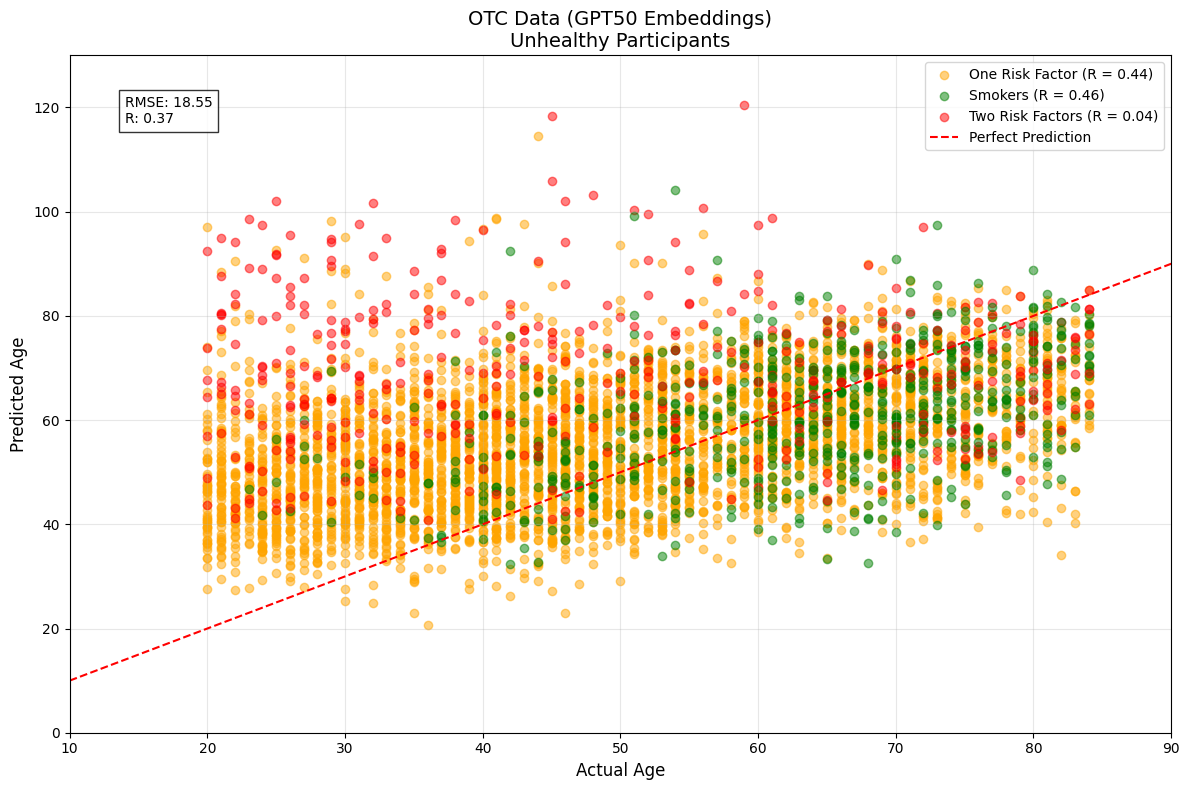


Detailed Statistics:
Number of smokers: 654

One Risk Factor:
Total participants: 4555
Number of smokers: 581
R: 0.436
Mean actual age: 50.06
Mean predicted age: 55.63

Two Risk Factors:
Total participants: 499
Number of smokers: 73
R: 0.041
Mean actual age: 51.39
Mean predicted age: 69.64


In [145]:
plt.figure(figsize=(12, 8))

colors = {1: 'orange', 2: 'red'}
labels = {1: 'One Risk Factor', 2: 'Two Risk Factors'}

r_by_risk = {}
for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    r_by_risk[n_risks] = stats.pearsonr(
        plot_data[mask]['actual'], 
        plot_data[mask]['predicted']
    )[0]
    
    # Split each risk group into smokers and non-smokers
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    smoker_r = stats.pearsonr(
        plot_data[smoker_mask]['actual'],
        plot_data[smoker_mask]['predicted']
    )[0]
    non_smoker_mask = mask & ~plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    # Plot non-smokers with original colors
    plt.scatter(
        plot_data[non_smoker_mask]['actual'], 
        plot_data[non_smoker_mask]['predicted'], 
        alpha=0.5, 
        color=colors[n_risks], 
        label=f"{labels[n_risks]} (R = {r_by_risk[n_risks]:.2f})"
    )
    
    # Plot smokers in green
    plt.scatter(
        plot_data[smoker_mask]['actual'], 
        plot_data[smoker_mask]['predicted'], 
        alpha=0.5, 
        color='green', 
        label=f"Smokers (R = {smoker_r:.2f})" if n_risks == 1 else ""  # Only add label once
    )

plt.plot([10, 130], [10, 130], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 130)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (GPT50 Embeddings)\nUnhealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

metrics_text = f'RMSE: {rmse_unhealthy_gpt50_otc:.2f}\nR: {r_unhealthy_gpt50_otc:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
smoker_mask = plot_data['SEQN'].isin(cig_risk['SEQN'])
print(f"Number of smokers: {smoker_mask.sum()}")

for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    print(f"\n{labels[n_risks]}:")
    print(f"Total participants: {mask.sum()}")
    print(f"Number of smokers: {smoker_mask.sum()}")
    print(f"R: {r_by_risk[n_risks]:.3f}")
    print(f"Mean actual age: {plot_data[mask]['actual'].mean():.2f}")
    print(f"Mean predicted age: {plot_data[mask]['predicted'].mean():.2f}")

Number of extreme over-predictions found: 663

Average actual age: 36.95
Average predicted age: 69.70


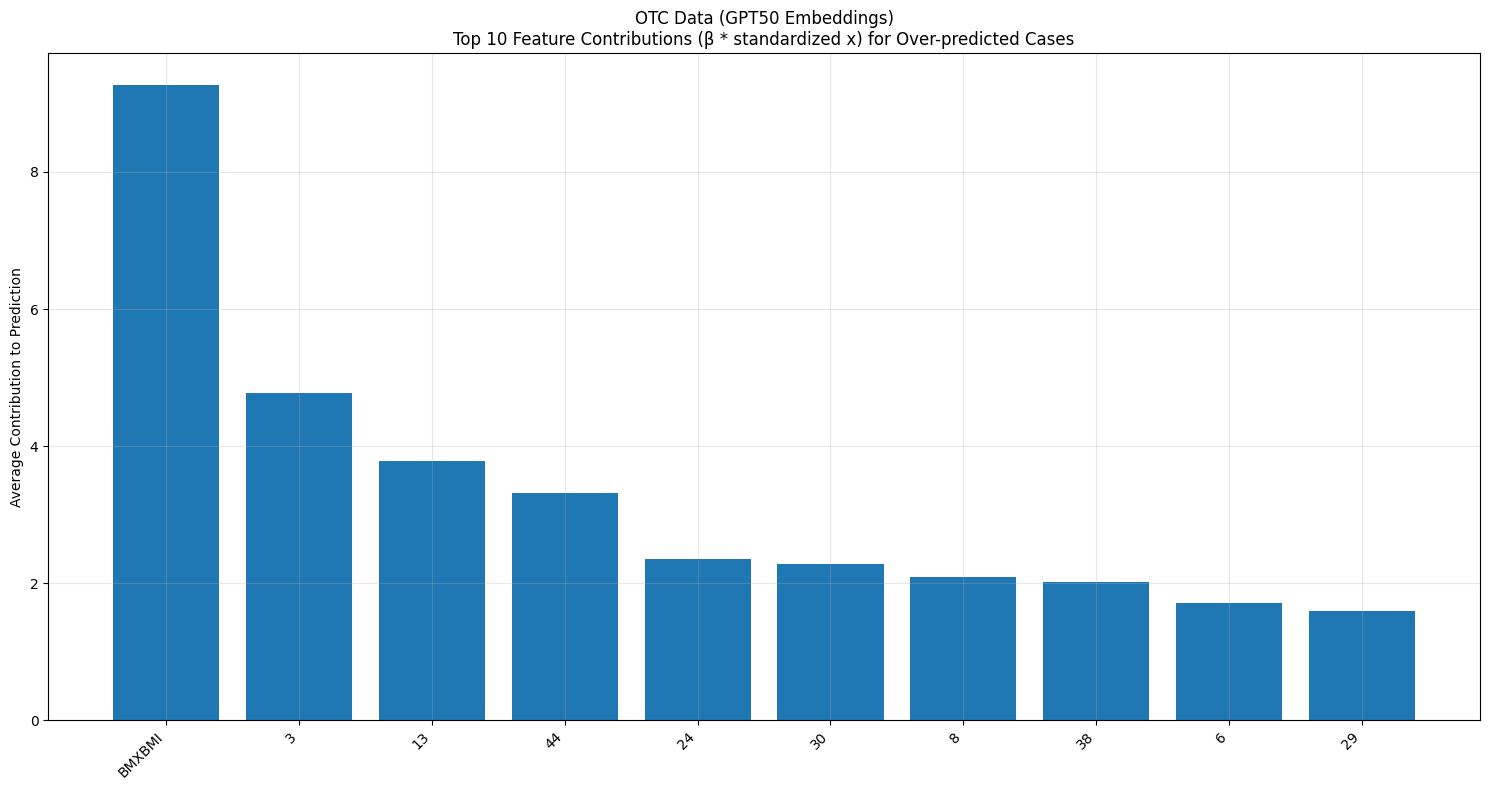


Detailed Analysis of Top Contributors:

Feature: BMXBMI
Beta (coefficient): 1.4397
Average standardized X value: 6.4393
Average contribution (β * standardized x): 9.2709
Range of standardized X values: -2.0796 to 55.0036

Feature: 3
Beta (coefficient): -6.4603
Average standardized X value: 0.7381
Average contribution (β * standardized x): 4.7684
Range of standardized X values: -2.0454 to 1.3807

Feature: 13
Beta (coefficient): -4.7330
Average standardized X value: -0.7986
Average contribution (β * standardized x): 3.7797
Range of standardized X values: -2.2212 to 2.9140

Feature: 44
Beta (coefficient): -6.1100
Average standardized X value: -0.5436
Average contribution (β * standardized x): 3.3214
Range of standardized X values: -1.3235 to 2.9134

Feature: 24
Beta (coefficient): -3.2554
Average standardized X value: -0.7221
Average contribution (β * standardized x): 2.3506
Range of standardized X values: -1.6323 to 5.3489

Feature: 30
Beta (coefficient): -3.1035
Average standardized X 

In [147]:
mask = (plot_data['actual'].between(20, 50)) & (plot_data['predicted'] > 60)
extreme_cases = plot_data[mask].copy()

extreme_features = X_unhealthy_scaled[X_unhealthy_scaled.index.isin(extreme_cases.index)]
coefficients = pd.Series(lr_gpt50_otc.coef_, index=X_unhealthy_scaled.columns)

feature_contributions = extreme_features * coefficients

avg_contributions = feature_contributions.mean()
top_contributors = avg_contributions.abs().sort_values(ascending=False).head(10)

print(f"Number of extreme over-predictions found: {len(extreme_cases)}")
print(f"\nAverage actual age: {extreme_cases['actual'].mean():.2f}")
print(f"Average predicted age: {extreme_cases['predicted'].mean():.2f}")

plt.figure(figsize=(15, 8))
plt.bar(range(len(top_contributors)), top_contributors.values)
plt.xticks(range(len(top_contributors)), top_contributors.index, rotation=45, ha='right')
plt.title('OTC Data (GPT50 Embeddings)\nTop 10 Feature Contributions (β * standardized x) for Over-predicted Cases')
plt.ylabel('Average Contribution to Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetailed Analysis of Top Contributors:")
for feature in top_contributors.index:
    print(f"\nFeature: {feature}")
    print(f"Beta (coefficient): {coefficients[feature]:.4f}")
    print(f"Average standardized X value: {extreme_features[feature].mean():.4f}")
    print(f"Average contribution (β * standardized x): {top_contributors[feature]:.4f}")
    print(f"Range of standardized X values: {extreme_features[feature].min():.4f} to {extreme_features[feature].max():.4f}")

### OTC Data GPT 1536

In [148]:
healthy_gpt1536_otc = gpt1536_otc[gpt1536_otc['SEQN'].isin(healthy_participants)]
unhealthy_gpt1536_otc = gpt1536_otc[gpt1536_otc['SEQN'].isin(unhealthy_participants)]

In [149]:
X = healthy_gpt1536_otc.drop(columns=["Age", 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors="ignore")
y = healthy_gpt1536_otc["Age"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

ridge_otc1536 = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
ridge_otc1536.fit(X_train_scaled, y_train)

y_pred_gpt1536_otc = ridge_otc1536.predict(X_test_scaled)
rmse_gpt1536_otc = np.sqrt(mean_squared_error(y_test, y_pred_gpt1536_otc))
r_gpt1536_otc = stats.pearsonr(y_test, y_pred_gpt1536_otc)[0]

print(f"RMSE for test set (healthy participants): {rmse_gpt1536_otc}")
print(f"R Squared for test set (healthy participants): {r_gpt1536_otc}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RMSE for test set (healthy participants): 15.085274583382589
R Squared for test set (healthy participants): 0.6184670029363513


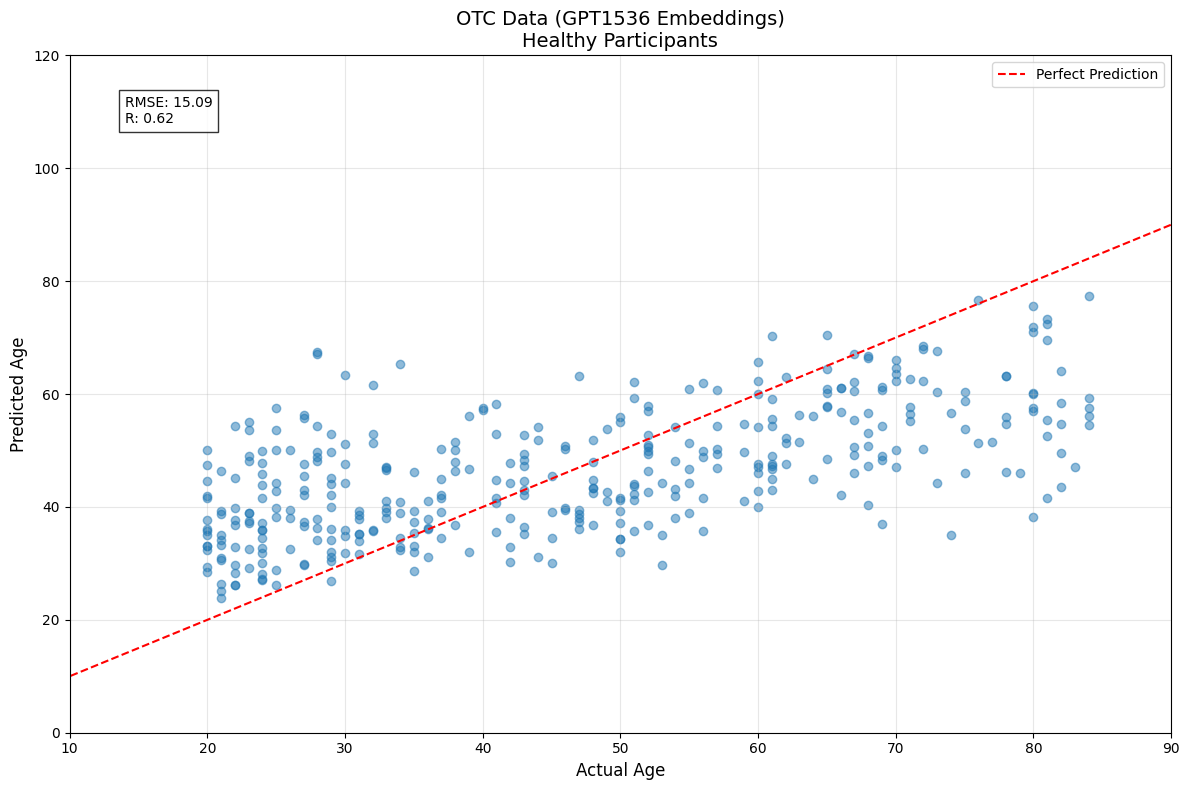


Prediction Statistics:
Mean Absolute Error: 12.20
Mean prediction: 46.26
Mean actual age: 46.51
Age range in test set: 20 to 84


In [150]:
plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred_gpt1536_otc, alpha=0.5)

plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 120)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (GPT1536 Embeddings)\nHealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()

metrics_text = f'RMSE: {rmse_gpt1536_otc:.2f}\nR: {r_gpt1536_otc:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nPrediction Statistics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt1536_otc):.2f}")
print(f"Mean prediction: {y_pred_gpt1536_otc.mean():.2f}")
print(f"Mean actual age: {y_test.mean():.2f}")
print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}")

In [151]:
X_unhealthy = unhealthy_gpt1536_otc.drop(columns=['Age', 'SEQN', 'Activity_Risk', 'BMI_Risk'], errors='ignore')
y_unhealthy = unhealthy_gpt1536_otc['Age']

X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

y_pred_gpt1536_otc_unhealthy = ridge_otc1536.predict(X_unhealthy_scaled)

In [152]:
unhealthy_gpt1536_otc['n_risks'] = (
    unhealthy_gpt1536_otc['Activity_Risk'].astype(int) + 
    unhealthy_gpt1536_otc['BMI_Risk'].astype(int)
)

plot_data = pd.DataFrame({
    'actual': y_unhealthy,
    'predicted': y_pred_gpt1536_otc_unhealthy,
    'SEQN': unhealthy_gpt1536_otc['SEQN']
})
plot_data = plot_data.merge(
    unhealthy_gpt1536_otc[['SEQN', 'n_risks']], 
    on='SEQN', 
    how='left'
)

rmse_unhealthy_gpt1536_otc = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt1536_otc_unhealthy))
r_unhealthy_gpt1536_otc = stats.pearsonr(y_unhealthy, y_pred_gpt1536_otc_unhealthy)[0]

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45488/2904853065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhealthy_gpt1536_otc['n_risks'] = (


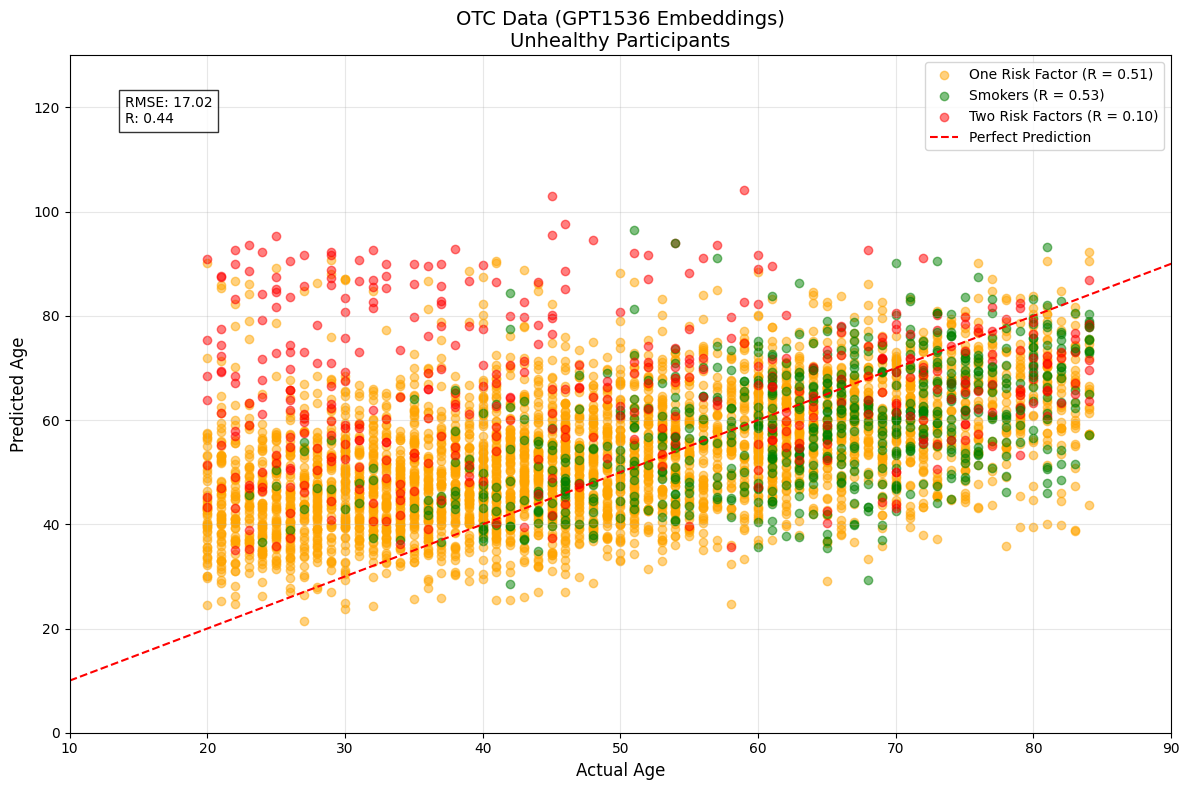


Detailed Statistics:
Number of smokers: 654

One Risk Factor:
Total participants: 4555
Number of smokers: 581
R: 0.508
Mean actual age: 50.06
Mean predicted age: 53.43

Two Risk Factors:
Total participants: 499
Number of smokers: 73
R: 0.101
Mean actual age: 51.39
Mean predicted age: 67.14


In [153]:
plt.figure(figsize=(12, 8))

colors = {1: 'orange', 2: 'red'}
labels = {1: 'One Risk Factor', 2: 'Two Risk Factors'}

r_by_risk = {}
for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    r_by_risk[n_risks] = stats.pearsonr(
        plot_data[mask]['actual'], 
        plot_data[mask]['predicted']
    )[0]
    
    # Split each risk group into smokers and non-smokers
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    smoker_r = stats.pearsonr(
        plot_data[smoker_mask]['actual'],
        plot_data[smoker_mask]['predicted']
    )[0]
    non_smoker_mask = mask & ~plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    # Plot non-smokers with original colors
    plt.scatter(
        plot_data[non_smoker_mask]['actual'], 
        plot_data[non_smoker_mask]['predicted'], 
        alpha=0.5, 
        color=colors[n_risks], 
        label=f"{labels[n_risks]} (R = {r_by_risk[n_risks]:.2f})"
    )
    
    # Plot smokers in green
    plt.scatter(
        plot_data[smoker_mask]['actual'], 
        plot_data[smoker_mask]['predicted'], 
        alpha=0.5, 
        color='green', 
        label=f"Smokers (R = {smoker_r:.2f})" if n_risks == 1 else ""  # Only add label once
    )


plt.plot([10, 130], [10, 130], 'r--', label='Perfect Prediction')

plt.xlim(10, 90)
plt.ylim(0, 130)

plt.xlabel('Actual Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('OTC Data (GPT1536 Embeddings)\nUnhealthy Participants', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

metrics_text = f'RMSE: {rmse_unhealthy_gpt1536_otc:.2f}\nR: {r_unhealthy_gpt1536_otc:.2f}'
plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
smoker_mask = plot_data['SEQN'].isin(cig_risk['SEQN'])
print(f"Number of smokers: {smoker_mask.sum()}")

for n_risks in [1, 2]:
    mask = plot_data['n_risks'] == n_risks
    smoker_mask = mask & plot_data['SEQN'].isin(cig_risk['SEQN'])
    
    print(f"\n{labels[n_risks]}:")
    print(f"Total participants: {mask.sum()}")
    print(f"Number of smokers: {smoker_mask.sum()}")
    print(f"R: {r_by_risk[n_risks]:.3f}")
    print(f"Mean actual age: {plot_data[mask]['actual'].mean():.2f}")
    print(f"Mean predicted age: {plot_data[mask]['predicted'].mean():.2f}")

Number of extreme over-predictions found: 452

Average actual age: 37.21
Average predicted age: 70.36


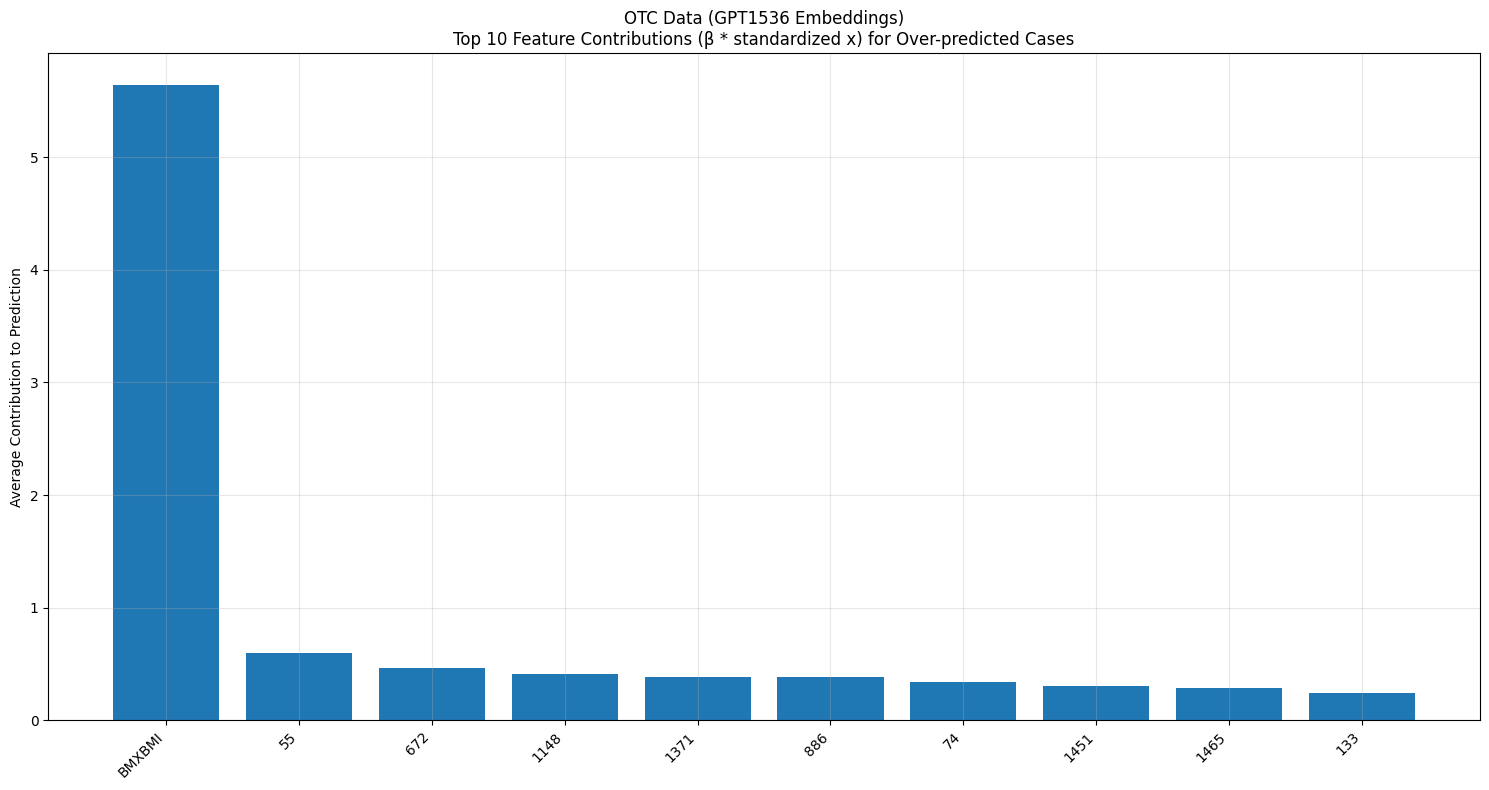


Detailed Analysis of Top Contributors:

Feature: BMXBMI
Beta (coefficient): 0.9396
Average standardized X value: 6.0054
Average contribution (β * standardized x): 5.6429
Range of standardized X values: -2.0796 to 55.0036

Feature: 55
Beta (coefficient): -0.4644
Average standardized X value: 1.2930
Average contribution (β * standardized x): 0.6005
Range of standardized X values: -2.8481 to 3.8060

Feature: 672
Beta (coefficient): 0.4184
Average standardized X value: -1.1185
Average contribution (β * standardized x): 0.4680
Range of standardized X values: -3.6359 to 2.4160

Feature: 1148
Beta (coefficient): 0.3040
Average standardized X value: 1.3423
Average contribution (β * standardized x): 0.4081
Range of standardized X values: -1.4630 to 3.6871

Feature: 1371
Beta (coefficient): -0.4462
Average standardized X value: -0.8630
Average contribution (β * standardized x): 0.3851
Range of standardized X values: -3.7997 to 1.5985

Feature: 886
Beta (coefficient): 0.3262
Average standardized

In [154]:
mask = (plot_data['actual'].between(20, 50)) & (plot_data['predicted'] > 60)
extreme_cases = plot_data[mask].copy()

extreme_features = X_unhealthy_scaled[X_unhealthy_scaled.index.isin(extreme_cases.index)]
coefficients = pd.Series(ridge_otc1536.coef_, index=X_unhealthy_scaled.columns)

feature_contributions = extreme_features * coefficients

avg_contributions = feature_contributions.mean()
top_contributors = avg_contributions.abs().sort_values(ascending=False).head(10)

print(f"Number of extreme over-predictions found: {len(extreme_cases)}")
print(f"\nAverage actual age: {extreme_cases['actual'].mean():.2f}")
print(f"Average predicted age: {extreme_cases['predicted'].mean():.2f}")

plt.figure(figsize=(15, 8))
plt.bar(range(len(top_contributors)), top_contributors.values)
plt.xticks(range(len(top_contributors)), top_contributors.index, rotation=45, ha='right')
plt.title('OTC Data (GPT1536 Embeddings)\nTop 10 Feature Contributions (β * standardized x) for Over-predicted Cases')
plt.ylabel('Average Contribution to Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetailed Analysis of Top Contributors:")
for feature in top_contributors.index:
    print(f"\nFeature: {feature}")
    print(f"Beta (coefficient): {coefficients[feature]:.4f}")
    print(f"Average standardized X value: {extreme_features[feature].mean():.4f}")
    print(f"Average contribution (β * standardized x): {top_contributors[feature]:.4f}")
    print(f"Range of standardized X values: {extreme_features[feature].min():.4f} to {extreme_features[feature].max():.4f}")